# Neural Networks with PyTorch

**Machine Learning - fall 2024**



__Notebook Author__: faeze abdoli



## Notebook Objectives

In this notebook we are going to implement and train a neural network with PyTorch!

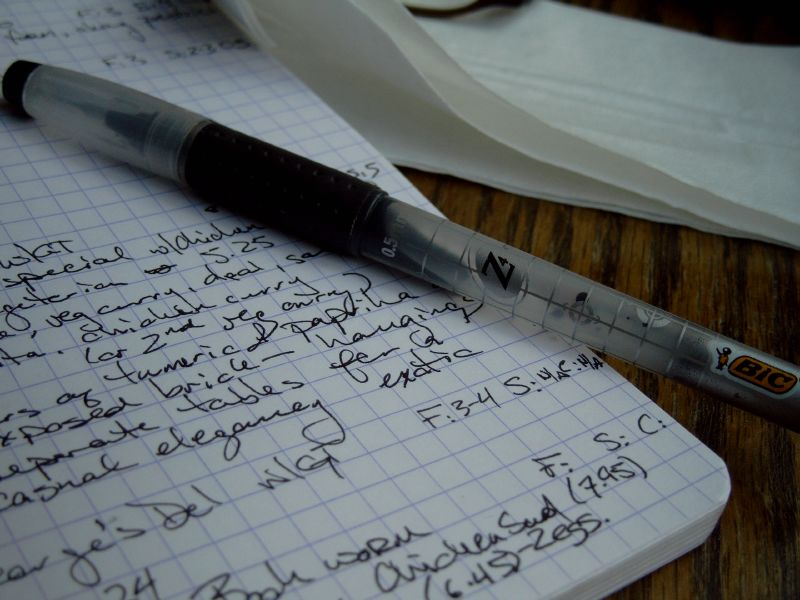

## Imports and Setup

We start by importing necessary modules. Don't worry if it seems a little overwhelming at first.😎😎

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# @title plotting functions

from matplotlib import pyplot as plt
from tqdm import trange

def visualize(images, labels):
    """
    Visualize a batch of images.
    """
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def visualize_predictions(images, labels, predicted_labels):
    """
    Visualize a batch of images with their true and predicted labels.
    Titles are green if the prediction is correct, red if incorrect.
    """
    fig, axes = plt.subplots(8, 8, figsize=(11, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        color = 'green' if labels[i].item() == predicted_labels[i].item() else 'red'
        ax.set_title(f'True: {labels[i].item()}\nPred: {predicted_labels[i].item()}', color=color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def plot_conf_mat(model, dataloader, device):
    """
    Plot the confusion matrix for a given model and dataloader.
    """
    # Initialize the confusion matrix
    total, correct = 0, 0
    conf_mat = torch.zeros((10, 10))
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total += pred.shape[0]
            pred = torch.argmax(pred, axis=1)
            correct += sum(pred == y).item()
            for j in range(pred.shape[0]):
                conf_mat[y[j], pred[j].item()] += 1
    # calculate the normalized confusion matrix
    norm_conf_mat = conf_mat / torch.sum(conf_mat, axis=1)
    # plot the matrix
    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.colorbar()
    # put number of each cell in plot
    for i in range(10):
        for j in range(10):
            c = conf_mat[j, i]
            color = 'black' if c > 500 else 'white'
            ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
    plt.show()

# Dataset

We will use `datasets` from `torchvision` to load the [MNIST](https://yann.lecun.com/exdb/mnist/) handwritten digits dataset. You can find the list of datasets available on torchvision [here](https://pytorch.org/vision/0.8/datasets.html). Now let's take a loot at the parameters we set:



*   `root` sets the directory we store and load our data from.
*   `train` indicates wether we want the training dataset or the test dataset.
*   `transform` allows us to apply transformations to our data, here we are only going to convert the data to tensor so that they work with PyToch, however in the future notebooks you will see more complicated transformations.



In [3]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train = True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False ,
    download=True,
    transform=ToTensor(), # Why Convert to Tensor? 👁‍🗨🧷
)


# print(f"Training data: {training_data}\n")
# print(f"Test data: {test_data}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.9MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



As you can see there are 60000 training samples in the training dataset and there are 10000 samples in the test dataset.

# Data Loaders

To make loading and working with the data easier, we are going to use `DataLoader` from `torch.utils.data`. The `DataLoader` takes in a dataset and a `batch_size` parameter, and allows us to iterate over the dataset. Here we do one iteration just to see the data shapes:

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Print the shape of the data to understand its dimensions and structure.  ❓🔧
for batch in train_dataloader:
    # Assuming each batch contains (inputs, labels)
    inputs, labels = batch
    print(inputs.shape)  # Prints the shape of the input data
    print(labels.shape)  # Prints the shape of the labels
    break  # Only need to print the first batch's shape

''' X [N, C, H, W] ,
N is the batch size (64 in this case).
C is the number of channels (1 for grayscale images like MNIST).
H and W are the height and width of the images (28x28 pixels for MNIST).'''

torch.Size([64, 1, 28, 28])
torch.Size([64])


' X [N, C, H, W] ,\nN is the batch size (64 in this case).\nC is the number of channels (1 for grayscale images like MNIST).\nH and W are the height and width of the images (28x28 pixels for MNIST).'

As you can see the `x`s are of shape `[64, 1, 28, 28]` which means we have a batch of `64` images, each with `1` channel which means the images are grayscale (for example colorful images have 3 channels of red, blue and green or RGB), and of size `28x28` pixels.

Similarly the `y`s are of shape `[64]` which means we have a batch of 64 labels. In the next section we will learn more about these labels.

# Visualization

Here we will take a look at single batch of data and visualize it.

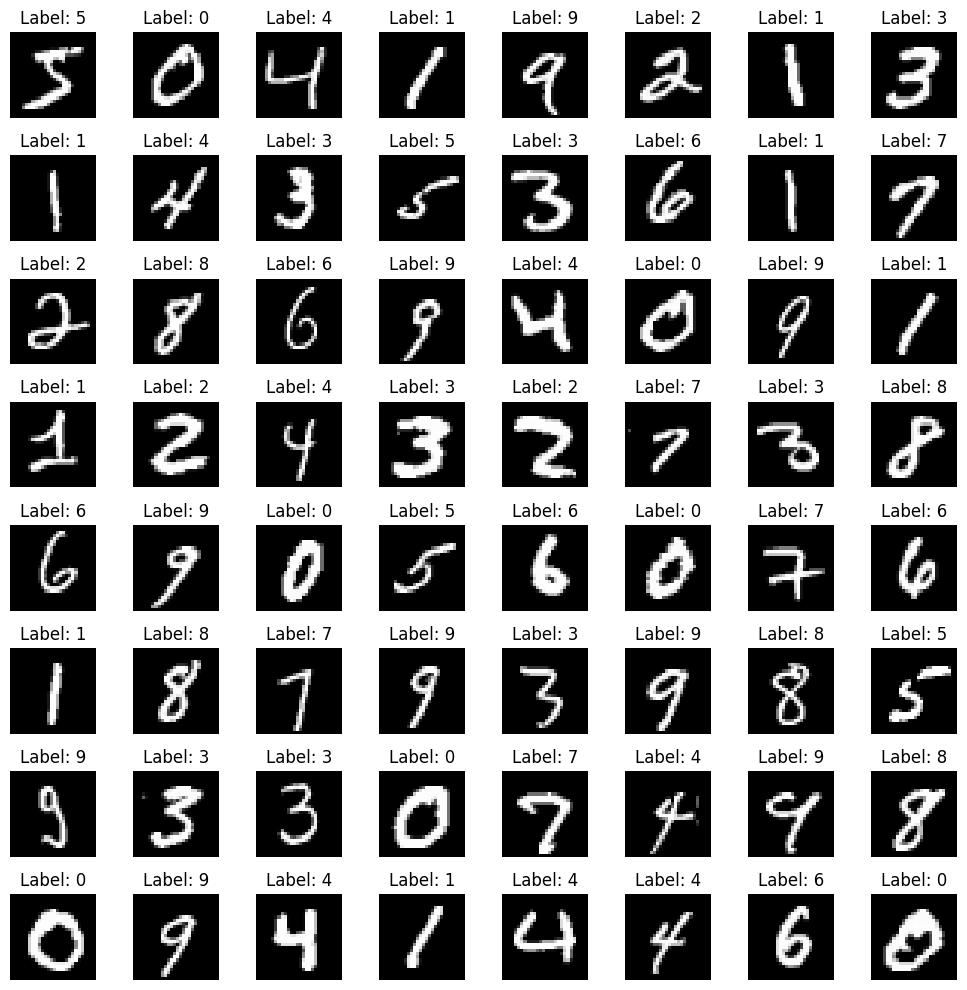

In [5]:
# Write code below to display single batch of data  📉📊
import matplotlib.pyplot as plt

# Get a batch of data
images, labels = next(iter(train_dataloader))

# Define grid size (e.g., 8x8 for 64 images)
grid_size = 8
plt.figure(figsize=(10, 10))

# Plot each image in the batch
for i in range(grid_size * grid_size):
    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(images[i].squeeze(), cmap="gray")  # Use squeeze to remove channel dimension
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")  # Hide axes for clarity

plt.tight_layout()
plt.show()


# Device

To accelerate operations in the neural network, we move it to the GPU or MPS (for Apple silicon) if available.

In [6]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Model

Here we define our model. Recall that each batch of image has a shape of `[64, 1, 28, 28]`. For now we only want to use `Linear` layers so we must **flatten** the inputs so that we can pass it to the linear layers. The `nn.Flatten()` module allows us to do this.

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 512),  # Input size is 784 after flattening
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)    # Output size is 10 for MNIST classes
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except the batch dimension
        logits = self.linear_relu_stack(x)
        return logits

Next we initialize our model.

In [8]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [9]:
from torchsummary import summary

summary(model, input_size=(1, 28, 28))  # Using (channels, height, width) for an image

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 512]         262,656
              ReLU-4                  [-1, 512]               0
            Linear-5                   [-1, 10]           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.55
Estimated Total Size (MB): 2.57
----------------------------------------------------------------


In [10]:
!pip install torch torchviz graphviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=271444b7b190e6c84a68e232cd16431f3dd7fd5ea91fb12ce1214d90ba06ae98
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [12]:
import torch
import torch.nn as nn
from torchviz import make_dot
input_tensor = torch.randn(1,1,28,28).to(device)
y = model(input_tensor)
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render("model_architecture", format="png")  # Save the visualization as a PNG file

'model_architecture.png'

# Loss Function

Since we are trying to classify the handwritten digits, we are going to use the ❓. You can see the list of loss functions in PyTorch [here](https://pytorch.org/docs/stable/nn.html#loss-functions).

In [13]:
loss_fn = nn.CrossEntropyLoss()

# Optimizer

Next we need to setup an optimizer for training our model.`. In the following sessions you will learn more about different optimizers but can also learn about the optimizers available on PyTorch [here](https://pytorch.org/docs/stable/optim.html).

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)

# Training

To train the model we first set the number of epochs. For each epoch we then iterate over the entire training data and update the model parameters. For each batch of data, we must first move the data to same device as the network, then we predict the output of the model, calculate the loss, perform backward pass, update parameters, and reset the gradients.

To monitor training, we use `trange` from `tqdm` which performs similar to `range` but allows us to have a progress bar `pbar` which lets us display useful information.

In [15]:
# Number of epochs we wish to train the model
n_epochs = 5

for _ in (pbar := trange(n_epochs)):
    # Iterate over the data
    for x, y in train_dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Predict the output and perform the forward pass
        pred = model(x)
        # Compute prediction error
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Clear the gradients
        optimizer.zero_grad()
        # Update the progress bar
        pbar.set_description(f'Loss = {loss.item():.3f}')

Loss = 0.010: 100%|██████████| 5/5 [01:00<00:00, 12.07s/it]


In the following notebooks we explore more advanced methods for monitoring the training but what you

# Evaluation

Finally we can evaluate the trained model. We will start by evaluating the model on the test dataset. Here we use `torch.no_grad()` since we don't need the gradients. We iterate over the entire test dataset and print the accuracy of our model on this dataset.

In [25]:
# Store the number of correctly classified and total labels
correct, total = 0, 0

# Disable gradient calculation
with torch.no_grad():
    # Iterate over the test data
    for x, y in test_dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Predict the output
        logits = model(x)
        # Get the predicted label
        pred = torch.argmax(logits, axis=1)
        # Update the number of correclty classified labels
        correct += (pred == y).sum().item()
        # Update the number of total labels
        total += pred.shape[0]

In [26]:
acc = correct / total
acc

0.9622

In [29]:
!pip -q install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 20.5 MB/s eta 0:00:00


In [32]:
'''Accuracy: The proportion of correctly classified instances.
Precision, Recall, and F1 Score: Metrics to assess the model’s performance across different classes.'''
import torchmetrics

NUM_CLASSES = 10  # Update this to match the number of classes in your dataset

# Define metrics with the required `task` parameter
accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(device)
precision = torchmetrics.Precision(task='multiclass', num_classes=NUM_CLASSES, average='weighted').to(device)
recall = torchmetrics.Recall(task='multiclass', num_classes=NUM_CLASSES, average='weighted').to(device)
f1_score = torchmetrics.F1Score(task='multiclass', num_classes=NUM_CLASSES, average='weighted').to(device)

# Iterate over the DataLoader
with torch.no_grad():
    for x, y in test_dataloader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = torch.argmax(logits, axis=1)

        # Update metrics
        accuracy.update(preds, y)
        precision.update(preds, y)
        recall.update(preds, y)
        f1_score.update(preds, y)

# Compute final metrics
print(f"Accuracy: {accuracy.compute():.4f}")
print(f"Precision: {precision.compute():.4f}")
print(f"Recall: {recall.compute():.4f}")
print(f"F1 Score: {f1_score.compute():.4f}")


Accuracy: 0.9622
Precision: 0.9626
Recall: 0.9622
F1 Score: 0.9621


Let's visuzlie a batch to compare the predictions and the true labels.

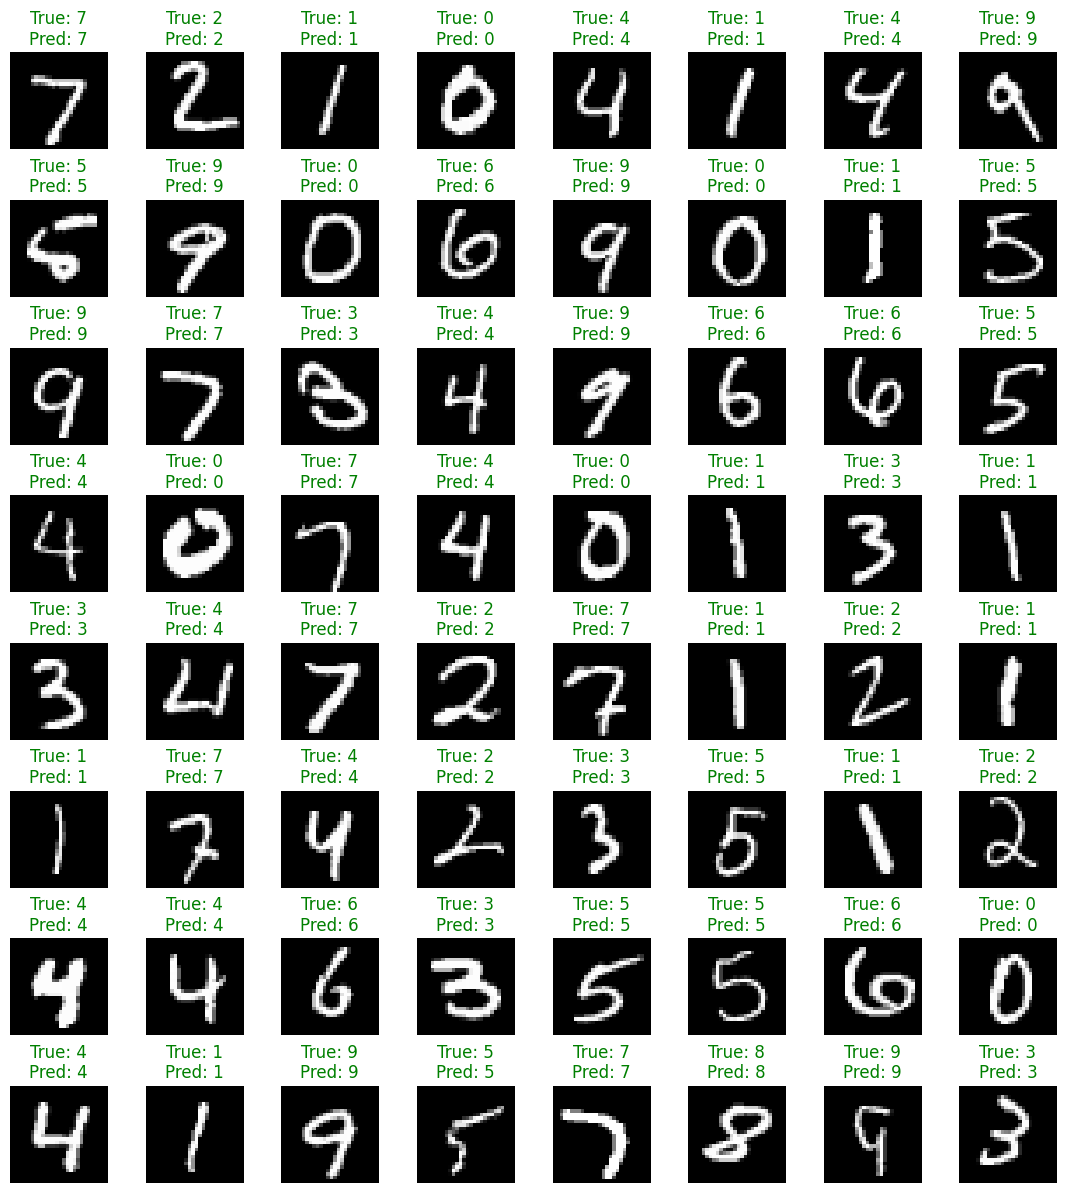

In [34]:
# Visualize the predictions alongside the original images and their true labels. ❓
images, labels = next(iter(test_dataloader))  # Get a batch of images and labels
images, labels = images.to(device), labels.to(device)  # Move to the same device as the model

# Get model predictions
with torch.no_grad():
    logits = model(images)  # Predict logits
    predicted_labels = torch.argmax(logits, dim=1)  # Convert logits to class predictions

# Visualize predictions
visualize_predictions(images.cpu(), labels.cpu(), predicted_labels.cpu())

To get a better sense of our model, we can plot it's confusion matrix.

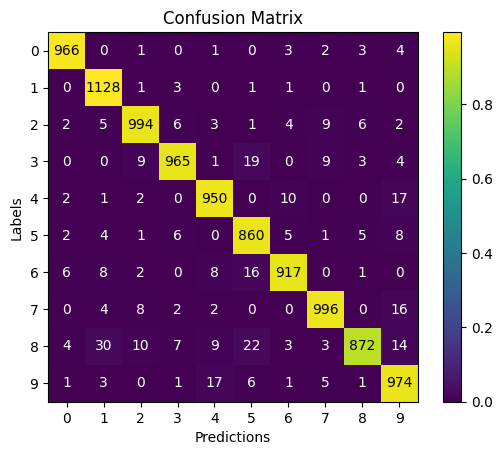

In [35]:
# confusion matrix
plot_conf_mat(model, test_dataloader, device)

# Experiments

Here we will take a look at different optimizers and how they effect training and convergence. Run the widget bellow to train the model for different optimizers! You can increase the number of epochs or set the hyperparameters of each optimizers manually if you like.

Loss = 0.201 | Accuracy = 94.34% : 100%|██████████| 10/10 [01:14<00:00,  7.44s/it]


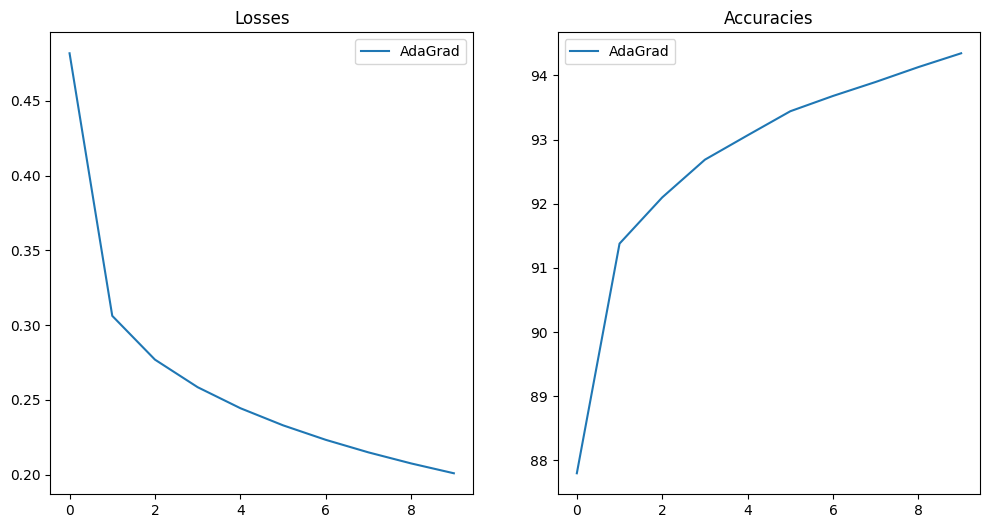

Dropdown(description='Optimizer:', layout=Layout(width='200px'), options=('SGD', 'AdaGrad', 'RMSProp', 'Adam')…


RMSProp


Loss = 0.011 | Accuracy = 99.64% : 100%|██████████| 10/10 [01:15<00:00,  7.54s/it]


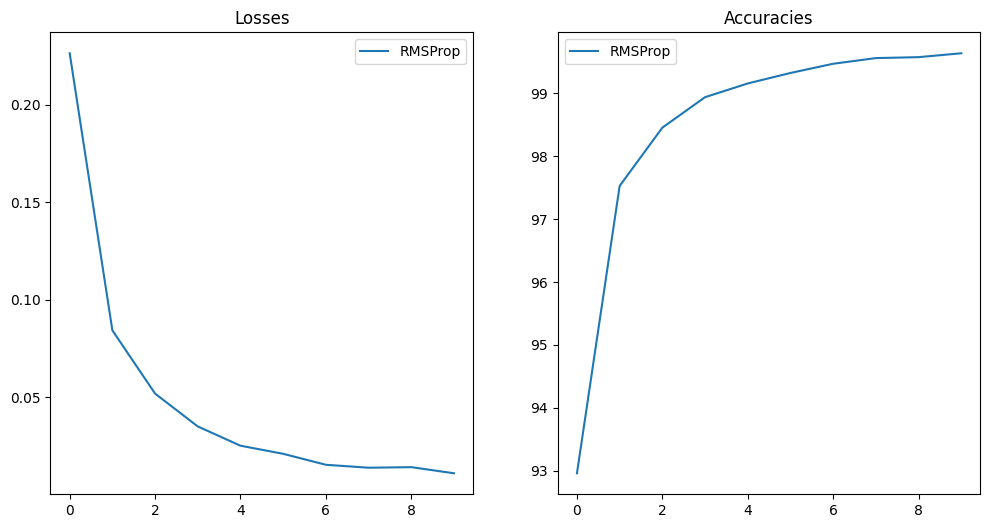


Adam


Loss = 0.013 | Accuracy = 99.56% : 100%|██████████| 10/10 [01:14<00:00,  7.48s/it]


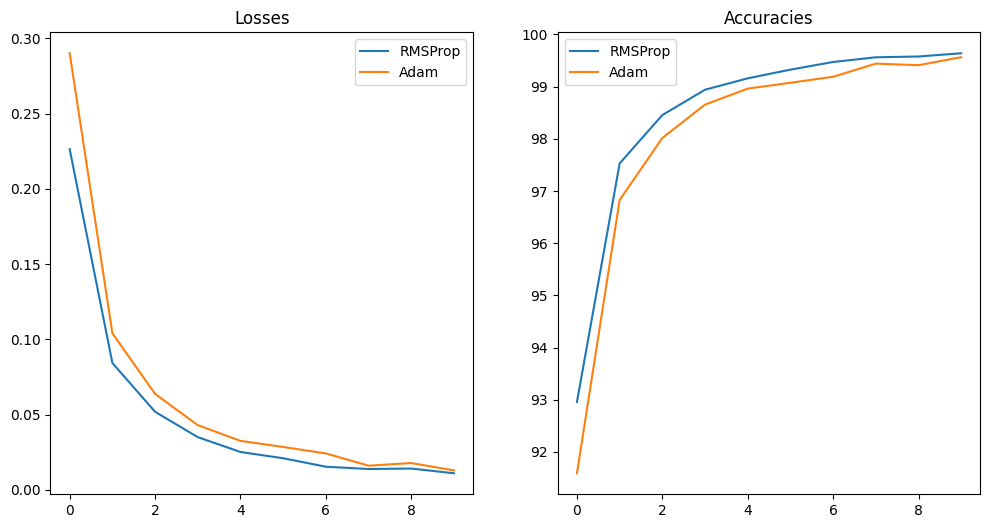


SGD


Loss = 1.652 | Accuracy = 71.23% : 100%|██████████| 10/10 [01:14<00:00,  7.41s/it]


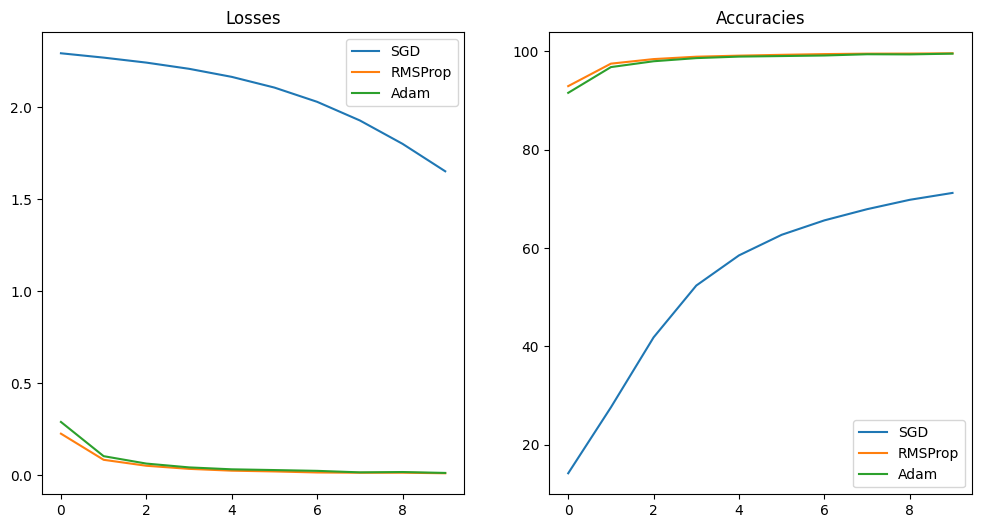


AdaGrad


Loss = 0.196 | Accuracy = 94.45% : 100%|██████████| 10/10 [01:15<00:00,  7.52s/it]


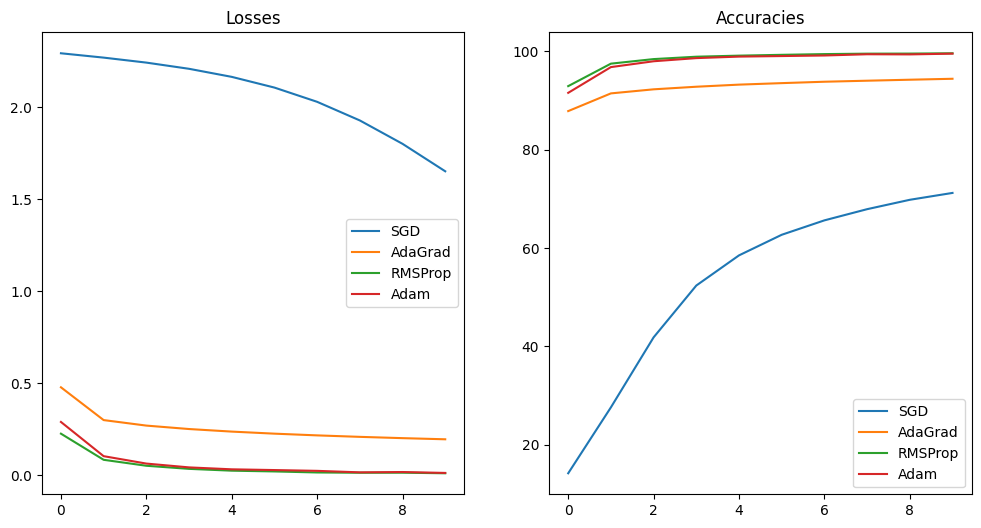

In [37]:
# @markdown Optimizer Experimentation Widget

import ipywidgets as widgets
from IPython.display import display

train_dataloader = DataLoader(training_data, batch_size=128)

def train_model(model, optimizer, n_epochs=10):
    losses, accuracies = [], []
    for _ in (pbar := trange(n_epochs)):
        running_loss, acc = 0, 0
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()
            pred = torch.argmax(pred, axis=1)
            acc += sum(pred == y).item()
        acc /= len(train_dataloader.dataset)
        acc *= 100
        running_loss /= len(train_dataloader)
        losses.append(running_loss)
        accuracies.append(acc)
        pbar.set_description(f'Loss = {running_loss:.3f} | Accuracy = {acc:.2f}% ')
    return losses, accuracies


def plot_losses_accuracies(results):
    fig, axes = plt.subplots(1, 2)
    for optimizer, res in results.items():
        if 'losses' not in res or 'accuracies' not in res:
            continue
        losses = res['losses']
        accuracies = res['accuracies']
        axes[0].plot(losses, label=optimizer)
        axes[1].plot(accuracies, label=optimizer)
    axes[0].set_title('Losses')
    axes[1].set_title('Accuracies')
    axes[0].legend()
    axes[1].legend()
    fig.set_size_inches(12, 6)
    plt.show()


# Create a list of values
options = ['SGD', 'AdaGrad', 'RMSProp', 'Adam']

# Create a dropdown widget with custom layout
dropdown = widgets.Dropdown(
    options=options,
    description='Optimizer:',
    layout={'width': '200px'},
    style={'description_width': 'initial'}

)

# Define a function to run based on selected value
def on_value_change(change):
    optimizer = change['new']
    global first_run, resuts
    model = NeuralNetwork().to(device)
    if results[optimizer] != {}:
        losses = results[optimizer]['losses']
        accuracies = results[optimizer]['accuracies']
        plot_losses_accuracies(results)
        return
    if optimizer == 'SGD':
        opt = torch.optim.SGD(model.parameters(), lr=1e-3)
    elif optimizer == 'AdaGrad':
        opt = torch.optim.Adagrad(model.parameters(), lr=1e-3)
    elif optimizer == 'RMSProp':
        opt = torch.optim.RMSprop(model.parameters(), lr=1e-3)
    elif optimizer == 'Adam':
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    print(f'\n{optimizer}')
    losses, accuracies = train_model(model, opt)
    results[optimizer]['losses'] = losses
    results[optimizer]['accuracies'] = accuracies
    plot_losses_accuracies(results)



# Observe changes in the dropdown value
dropdown.observe(on_value_change, names='value')

results = {optimizer: dict() for optimizer in options}

# on_value_change({"new": 'SGD'})

# Display the widget
display(dropdown)


# Refrences


*   [Learn the Basics of PyTorch](https://pytorch.org/tutorials/beginner/basics/intro.html)
*   [Neural networks](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) from [3Blue1Brown](https://www.3blue1brown.com/)

